# Imports

In [1]:
# Data processing 
import numpy as np
import pandas as pd

# Data visualisation
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mpl.rc('axes',  labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Commons
import os
import math
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Constants

In [2]:
ARTICLES_CSV_PATH     = '../input/h-and-m-personalized-fashion-recommendations/articles.csv'
CUSTOMERS_CSV_PATH    = '../input/h-and-m-personalized-fashion-recommendations/customers.csv'
TRANSACTIONS_CSV_PATH = '../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
ARTICLES_IMAGES_PATH  = '../input/h-and-m-personalized-fashion-recommendations/images'

COLORS = ['grey', 'lightcoral', 'tomato', 'coral','chocolate', 'tan',
          'lawngreen', 'aquamarine', 'darkcyan', 'deepskyblue', 'navy',
          'crimson', 'orchid', 'mediumorchid', 'orange', 'slateblue',
          'cadetblue', 'mediumspringgreen', 'lightseagreen']

# Utils functions

In [3]:
def stop_execution():
    """
    Stop the execution of the program
    """
    raise SystemExit()
    

def csv_to_pd(csv_path):
    """ 
    Convert a `csv` file to `pandas Dataframe`
    If the given file path is not correct, then `None` is returned
    
    @param `csv_path`: Path to the csv file
    @return: Parsed csv file or `None`
    @rtype: pandas.Dataframe    
    """
    
    if not os.path.isfile(csv_path):
        print(f"The file '{csv_path}' doesn't exist!")
        return None
    return pd.read_csv(csv_path)


def plot_missing_values(data):
    """
    Plot the NaNs percentages of each column of the pd df
    
    @param `data`: Pandas Dataframe to be analysed
    """
    
    if data.isna().sum().sum() == 0:
        print('Zero missing values')
        return
    
    # Compute the df with the NAs and drop the non-missing values
    na_df = (data.isna().sum() / len(data)) * 100      
    na_df = na_df                       \
        .drop(na_df[na_df == 0].index)  \
        .sort_values(ascending=False)
    
    # Plot the NAs df
    missing_data = pd.DataFrame({'Missing Ratio %': na_df})
    missing_data.plot(kind='barh')
    
    plt.tight_layout()
    plt.show()

In [4]:
def filter_outliers(data, threshold=0.95):
    """
    Filter the data. Remove the least (1-threshold) semnificative instances
    
    @param `data`: Input table (pd df)
    @param `threshold`: The strength of the filtering (1-threshold) 
    """
    
    min_count = data.loc[data['count'].idxmin()][1]
    max_count = data.loc[data['count'].idxmax()][1]
    computed_threshold = (max_count - min_count) * (1 - threshold)
    return data[data['count'] > computed_threshold]

    
def group_data_by(data, groupby, countby):
    """
    Group data based on the column `groupby`
    and count values by after the `countby` param
    
    @param `data`: Pandas Dataframe to be grouped
    @param `groupby`: Key used to group the data
    @param `countby`: Count the instances based on this key
    @return: pd df with 2 columns: `groupby` and `count`
    @rtype: Pandas Dataframe
    """
    
    # Check if the param `groupby` is a nested list 
    if not any(isinstance(x, list) for x in groupby):
        group_by = groupby
    else:
        group_by = [groupby]
    
    grouped_data = data                  \
        .groupby(group_by)               \
        .count()[countby]                \
        .sort_values(ascending=False)    \
        .reset_index()
    return grouped_data.rename(columns={countby: 'count'})

In [5]:
def plot_sns_lineplot(x, y, x_label='', y_label='', draw_pareto_line=False):
    """
    Plot a function given the x and y values
    
    @param `x`: X-axis discrete points
    @param `y`: Y-axis discrete values (e.g: f(x))
    @param `x_label`: Label of the X-axis plot
    @param `y_label`: Label of the Y-axis plot
    @param `draw_pareto_line`: Mark the 20-80 lines on the plot
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.lineplot(x=x, y=y)
    
    if draw_pareto_line:
        ax = sns.lineplot(x=[0.2, 0.2], y=[min(y), 0.8], linewidth=3, color='r', estimator=None)
        ax = sns.lineplot(x=[min(x), 0.2], y=[0.8, 0.8], linewidth=3, color='r', estimator=None)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.tight_layout()
    plt.show()


def plot_sns_hist(data, x, x_label='', y_label='', vertical=False, **kwargs):
    """ 
    Plot a histogram to show distributions of the dataset
    
    @param `data`: Input data structure (e.g: pd df)
    @param `x`: Variable that specify position on the y axes (e.g: pd df column name)
    @param `x_label`: Label of the X-axis histogram plot
    @param `y_label`: Label of the Y-axis histogram plot
    @param `**kwargs`: Other parameters for `histplot` function
    """
        
    if vertical:
        kwargs['x'] = x
    else:
        kwargs['y'] = x
        x_label, y_label = y_label, x_label
    
    fig, ax = plt.subplots(figsize=(20, 8))
    ax = sns.histplot(data=data, **kwargs)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.tight_layout()
    plt.show()
    

def plot_sns_bar(x, y, x_label='', y_label='', vertical=False, **kwargs):
    """ 
    Graph a bar plot
    
    @param `x`: X-axis values
    @param `y`: Y-axis values
    @param `x_label`: Label of the X-axis bar plot
    @param `y_label`: Label of the Y-axis bar plot
    @param `**kwargs`: Other parameters for `barplot` function
    """
    
    # Choose a random color if not given
    if 'color' not in kwargs:
        kwargs['color'] = random.choice(COLORS)
    
    # Compute the figure size
    x_sz = 10
    y_sz = math.floor(0.25 * len(y)) if len(y) > 10 else 10
    if vertical:
        x, y = y, x
        x_sz, y_sz = y_sz, x_sz
        kwargs['orient'] = 'v'
    
    fig, ax = plt.subplots(figsize=(x_sz, y_sz))
    ax = sns.barplot(x=x, y=y, **kwargs)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if not x_label:
        ax.set(xticklabels=[])
        
    if not y_label:
        ax.set(yticklabels=[])
    
    plt.tight_layout()
    plt.show()
    
    
def plot_sns_boxplot(data, x='', y=''):
    """ 
    Graph a box plot
    
    @param `data`: Input table (pd df)
    @param `x`: X-axis values (column's name)
    @param `y`: Y-axis values (for multiple boxplots)
    """
        
    fig, ax = plt.subplots(figsize=(15, 6))
    if not y:
        ax = sns.boxplot(data=data, x=x, color='xkcd:cerulean')
    else:
        sns.set_style('darkgrid')
        ax = sns.boxplot(data=data, x=x, y=y)
    ax.set_xlabel(x)
    plt.show()
    

def plot_sns_color_pallete(data, labels=None):
    """ 
    Graph a pie chart
    
    @param `data`: Values of labels
    @param `labels`: Labels to plot on pie
    """
    
    fig, ax = plt.subplots(figsize=(20, 8))
    colors = sns.color_palette('pastel')
    
    ax.pie(data, labels=labels, colors=colors, autopct='%1.1f%%')
    ax.set_facecolor('lightgrey')
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_articles_images(data):
    """
    Plot images of certain articles
    
    @param `data`: Input Pandas Dataframe for plotting the images 
    """
    
    fig, ax = plt.subplots(1, data.shape[0], figsize=(20, 10))
    i = 0

    # For each article
    for _, data in data.iterrows():
        # Compute description with a new line after 5 words
        description = articles[articles['article_id'] == data['article_id']]['detail_desc'].iloc[0]
        description_list = description.split(' ')
        for j, elem in enumerate(description_list):
            if j > 0 and j % 5 == 0:
                description_list[j] = description_list[j] + '\n'
        description = ' '.join(description_list)

        # Plot the image
        img = mpimg.imread(f"{ARTICLES_IMAGES_PATH}/0{str(data['article_id'])[:2]}/0{int(data['article_id'])}.jpg")
        ax[i].imshow(img)

        # Add title and description
        ax[i].set_title(f'price: {data.price:.4f}')
        ax[i].set_xlabel(description, fontsize=10)

        # Disable axes and grid
        ax[i].set_xticks([], [])
        ax[i].set_yticks([], [])
        ax[i].grid(False)

        # Move to the next article
        i += 1
    plt.show()

# Load the data

In [7]:
articles     = csv_to_pd(ARTICLES_CSV_PATH)
customers    = csv_to_pd(CUSTOMERS_CSV_PATH)
transactions = csv_to_pd(TRANSACTIONS_CSV_PATH)

# Sanity check
if any(pd_df is None for pd_df in [articles,
                                   customers,
                                   transactions]):
    stop_execution()

## Let's tackle each dataframe

In [8]:
# Show all columns in the dataframes
pd.set_option('display.max_columns', None)

# 1. Articles

In [9]:
# ~100k articles and 25 attributes
articles.shape

(105542, 25)

In [10]:
# We can group the attributes as follows:

# (product_code, product_name)
# (product_type_no, product_type_name)
# product_group_name
# (graphical_appearance_no, graphical_appearance_name)
# (colour_group_code, colour_group_name)
# (perceived_colour_value_id, perceived_colour_value_name)
# (perceived_colour_master_id, perceived_colour_master_name)
# (department_no, department_name)
# (index_code, index_name)
# (index_group_no, index_group_name)
# (section_no, section_name)
# (garment_group_no, garment_group_name)
# detail_desc

# You can see a lot of pairs of type (id, name).
# That means we can only use the `numerical attributes` or the `categorical attributes` when we will train the models.
# The `name` fields are very important for human readability when investigating the data. 

In [11]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [12]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

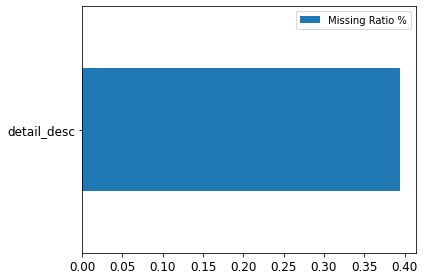

In [13]:
# Only the `detail_desc` has missing values (0.4%), which is good
plot_missing_values(articles)

### index_name

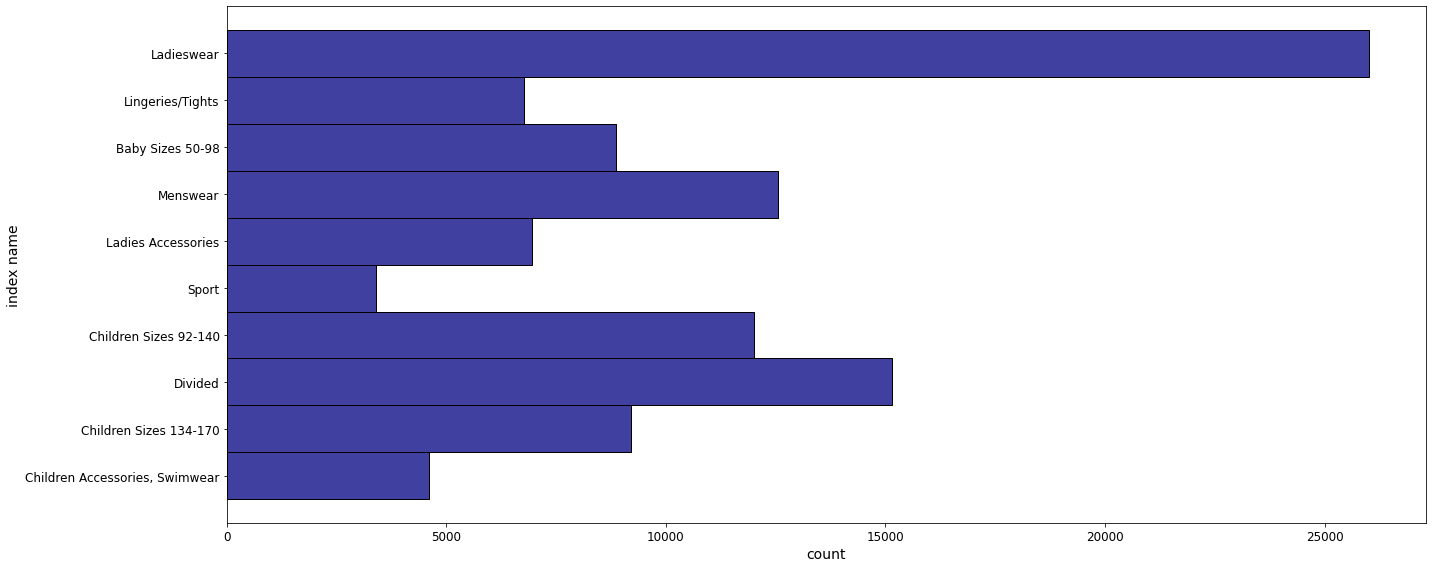

In [14]:
# From the plot below, we can see that H&M has a lot of `ladieswear` and very little `sportwear`
plot_sns_hist(data=articles,
              x='index_name',
              x_label='index name',
              y_label='count',
              color='navy')

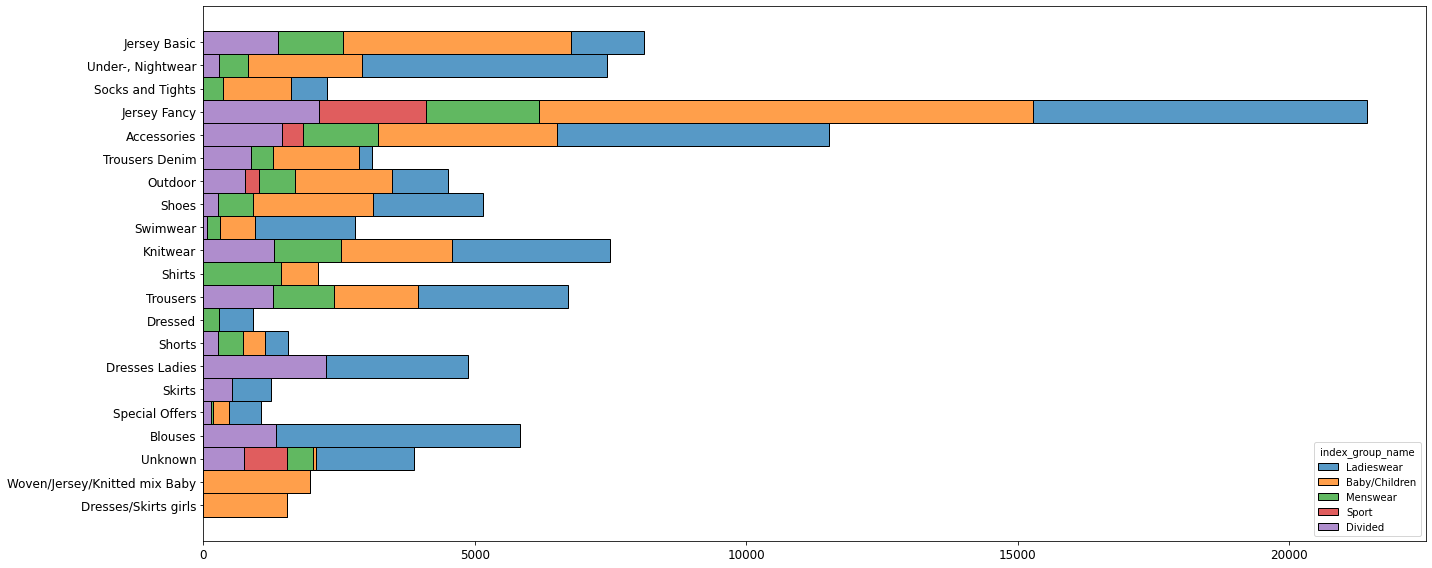

In [15]:
# `Jersey Fancy` is the most frequent garment, especially for children and women
# The `Sport` group is very sparse
plot_sns_hist(data=articles,
              x='garment_group_name',
              hue='index_group_name',
              multiple='stack')

### product_group

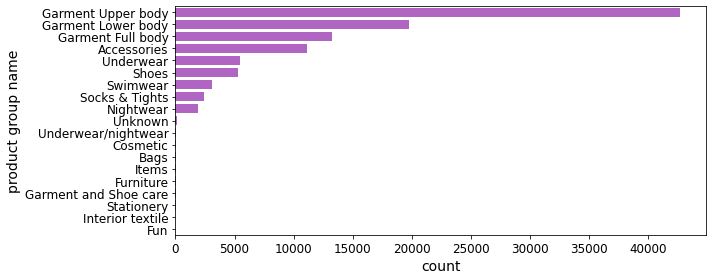

In [16]:
# Let's group the articles by `product_group_name` and count how many articles we have in each group.
product_group_name_sorted = group_data_by(data=articles,
                                          groupby='product_group_name',
                                          countby='article_id')

# Then, graph a bar plot
plot_sns_bar(x=product_group_name_sorted['count'],
             y=product_group_name_sorted['product_group_name'],
             x_label='count',
             y_label='product group name')

In [17]:
# Let's plot a pie chart with the most semnificative `product_groups`
pie_data = filter_outliers(data=product_group_name_sorted, threshold=0.95)
pie_data

,product_group_name,count
0,Garment Upper body,42741
1,Garment Lower body,19812
2,Garment Full body,13292
3,Accessories,11158
4,Underwear,5490
5,Shoes,5283
6,Swimwear,3127
7,Socks & Tights,2442


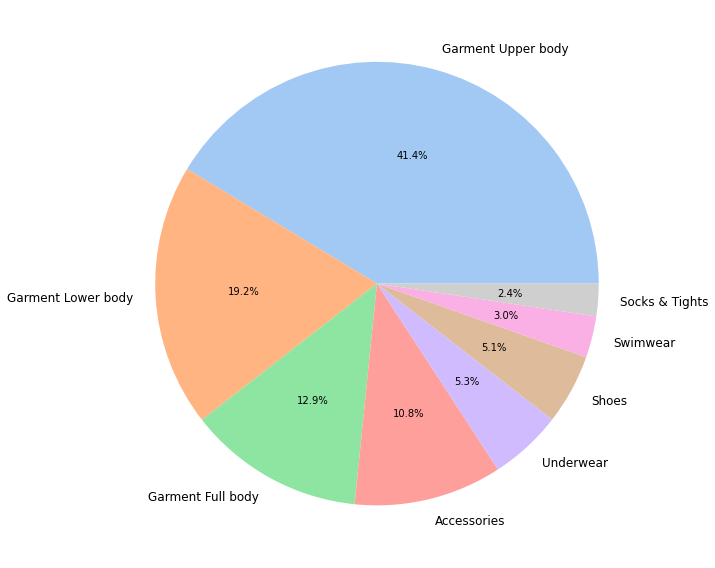

In [18]:
plot_sns_color_pallete(data=pie_data['count'],
                       labels=pie_data['product_group_name'])

### product_type

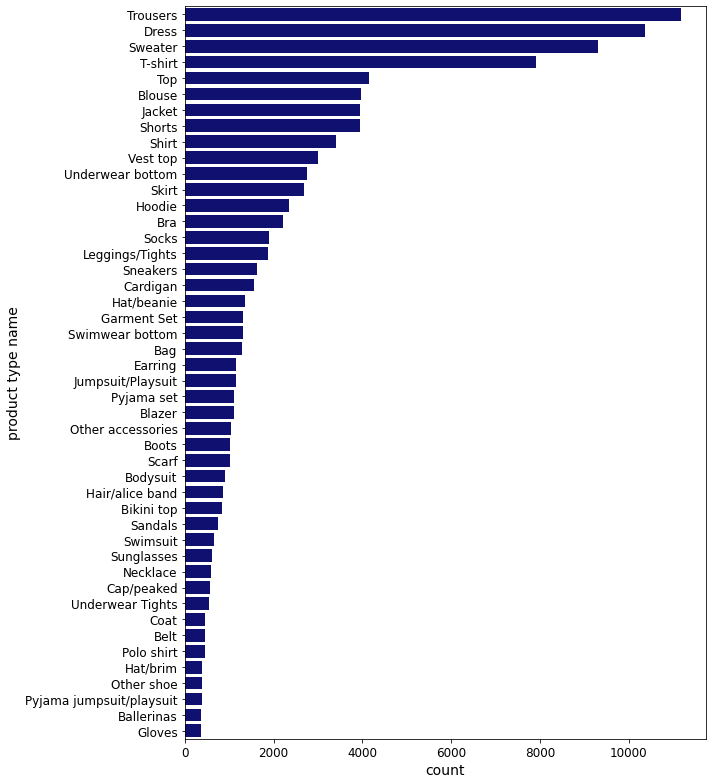

In [19]:
# Let's group the articles by `product_type_name` and count how many articles we have of each type.
product_type_name_sorted = group_data_by(data=articles,
                                         groupby='product_type_name',
                                         countby='article_id')

# Filter the outliers (look only at the most relevant `product_types`)
product_type_name_filtered = filter_outliers(data=product_type_name_sorted, threshold=0.97)

# Then, graph a bar plot
plot_sns_bar(x=product_type_name_filtered['count'],
             y=product_type_name_filtered['product_type_name'],
             x_label='count',
             y_label='product type name',
             color='navy')

### graphical_appearance

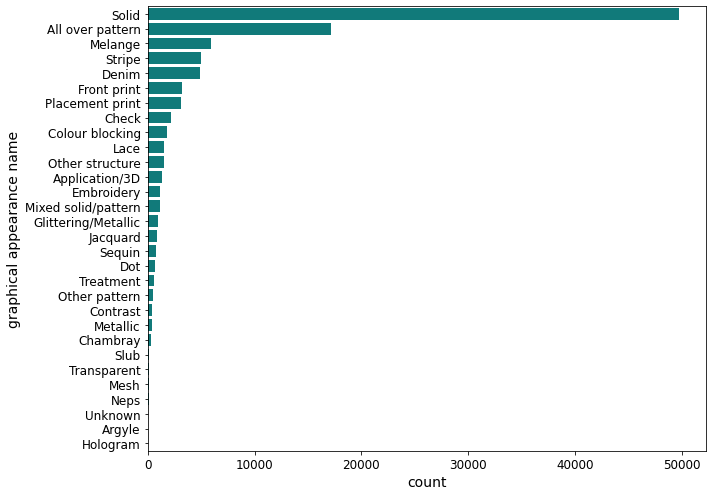

In [20]:
# Let's group the articles by `graphical_apperance_name` and count how many articles we have in each group.
graphical_appearance_sorted = group_data_by(data=articles,
                                            groupby='graphical_appearance_name',
                                            countby='article_id')

# Then, graph a bar plot
plot_sns_bar(x=graphical_appearance_sorted['count'],
             y=graphical_appearance_sorted['graphical_appearance_name'],
             x_label='count',
             y_label='graphical appearance name',
             color='darkcyan')

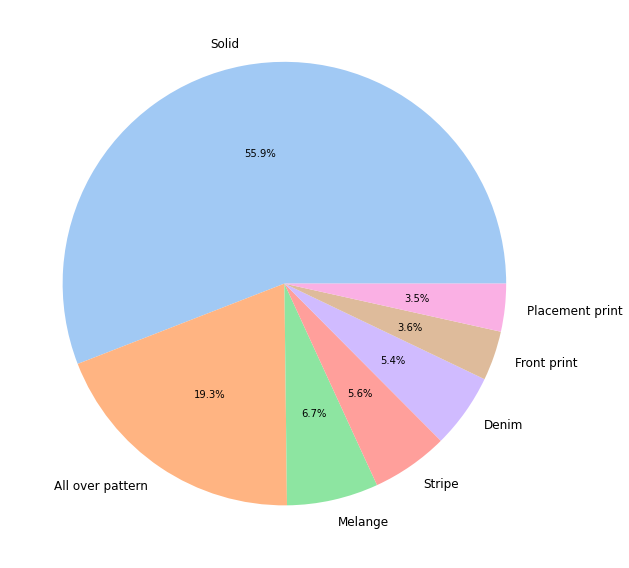

In [21]:
# We can also plot a pie chart with the most semnificative `graphical_appearances`
graphical_appearance_filtered = filter_outliers(data=graphical_appearance_sorted)
plot_sns_color_pallete(data=graphical_appearance_filtered['count'],
                       labels=graphical_appearance_filtered['graphical_appearance_name'])

### color_group

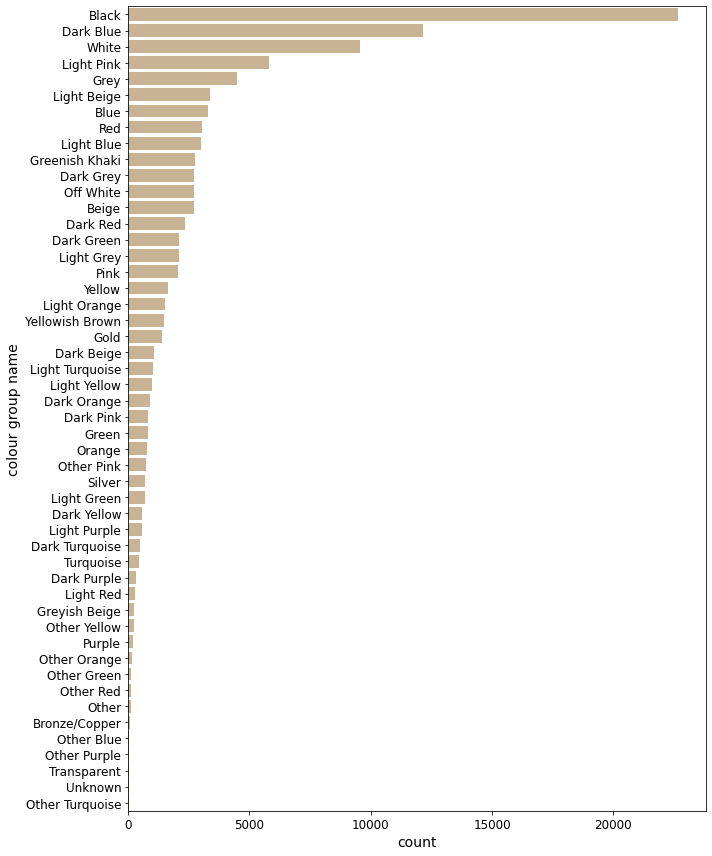

In [22]:
# Let's group the articles by `color_group_name` and count how many articles we have in each group.
color_group_sorted = group_data_by(data=articles,
                                   groupby='colour_group_name',
                                   countby='article_id')

# Then, graph a bar plot
plot_sns_bar(x=color_group_sorted['count'],
             y=color_group_sorted['colour_group_name'],
             x_label='count',
             y_label='colour group name')

# 2. Customers

In [23]:
# ~1.3mil customers and 7 attributes
customers.shape

(1371980, 7)

In [24]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


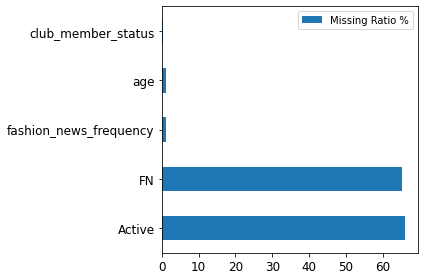

In [25]:
# The `customers` df has a lot of missing values on the `FN` and `Active` columns
plot_missing_values(customers)

In [26]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


### age

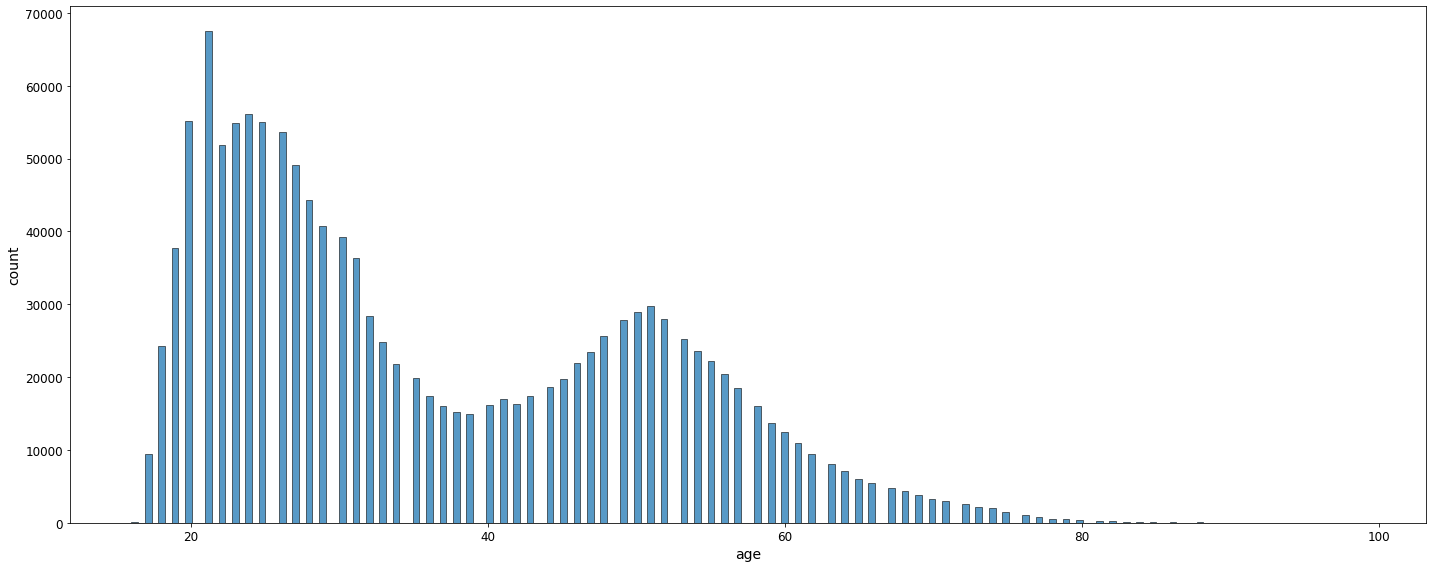

In [27]:
# The distribution is not a Gaussian one, but we can look at it within 2 ranges: [10, 40] and [40, 80]
# If we take a look at those 2 distributions separately, we can compare them with a Normal Distribution
# The common ages are 20-25 in the first frame and 50-55 in the second one
plot_sns_hist(data=customers,
              x='age',
              x_label='age',
              y_label='count',
              vertical=True)

### age_outliers

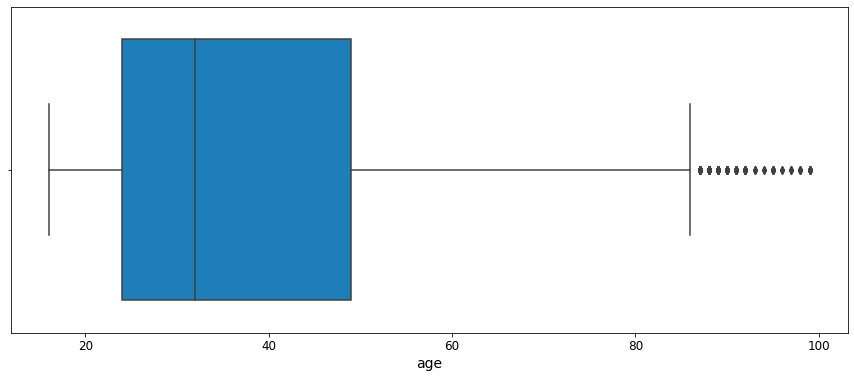

In [28]:
# We can see that the data is `right skewed`. It's also obvious from the above distribution.
# It means that the data constitute higher frequency of low valued scores.
plot_sns_boxplot(data=customers, x='age')

### club_member_status

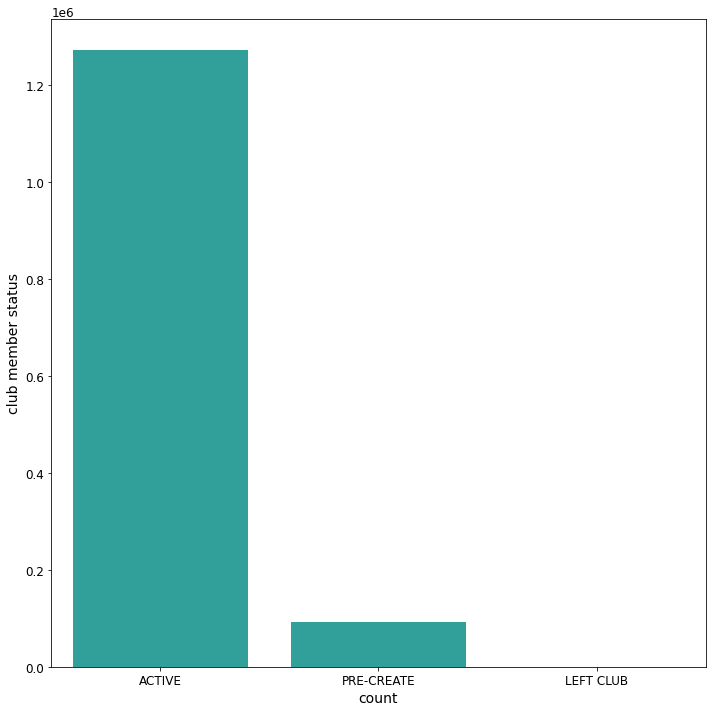

In [29]:
# Let's group the customers by `club_member_status` and count how many customers we have in each group.
club_member_status_sorted = group_data_by(data=customers,
                                          groupby='club_member_status',
                                          countby='customer_id')

# Then, graph a bar plot
plot_sns_bar(x=club_member_status_sorted['count'],
             y=club_member_status_sorted['club_member_status'],
             x_label='count',
             y_label='club member status',
             vertical=True)

### fashion_news_frequency

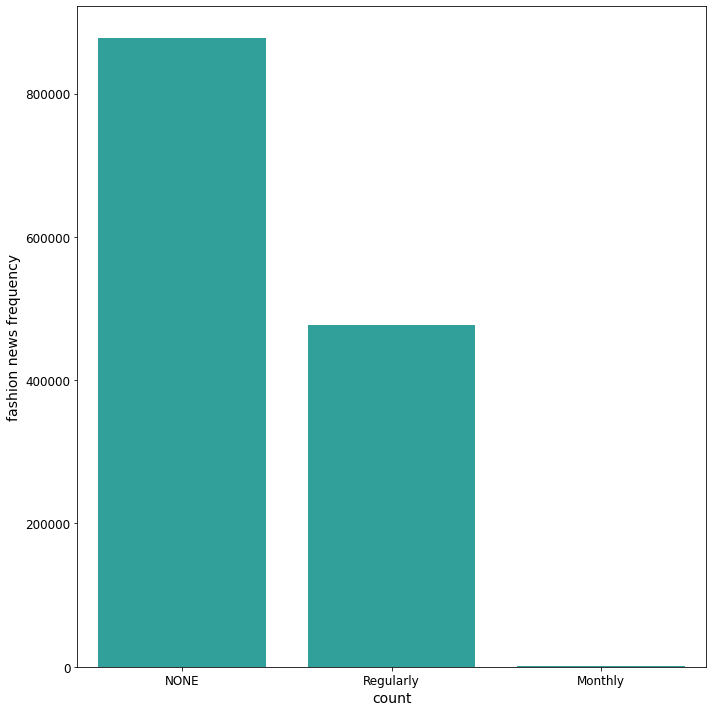

In [30]:
# Let's group the customers by `fashion_news_frequency` and count how many customers we have in each group.
fashion_news_frequency_sorted = group_data_by(data=customers,
                                              groupby='fashion_news_frequency',
                                              countby='customer_id')
fashion_news_frequency_sorted.drop([3], inplace=True)

# Then, graph a bar plot
plot_sns_bar(x=fashion_news_frequency_sorted['count'],
             y=fashion_news_frequency_sorted['fashion_news_frequency'],
             x_label='count',
             y_label='fashion news frequency',
             vertical=True)

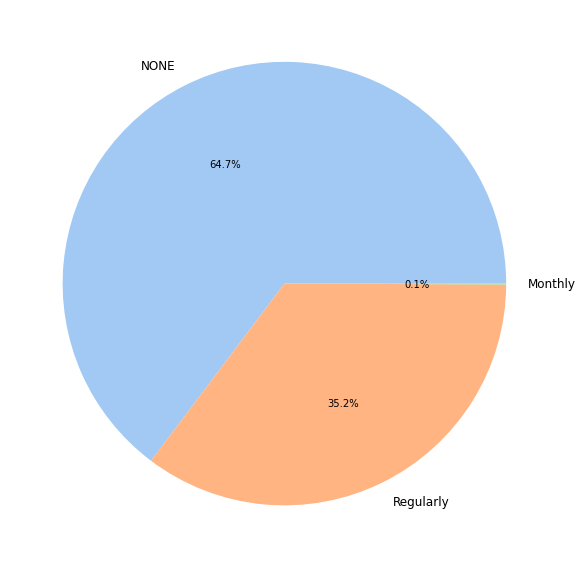

In [31]:
# As we can see, customers prefer not to get any messages about the news
plot_sns_color_pallete(data=fashion_news_frequency_sorted['count'],
                       labels=fashion_news_frequency_sorted['fashion_news_frequency'])

# 3. Transactions

In [32]:
# ~31mil transactions and 5 attributes
transactions.shape

(31788324, 5)

In [33]:
# `customer_id` is also present in the `customers` df and `article_id` in the `articles` df
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [34]:
plot_missing_values(transactions)

Zero missing values


In [35]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [36]:
transactions.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

In [37]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [38]:
# Let's convert the `t_dat` attribute into pd df datetime
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

In [39]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB


In [40]:
transactions.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2


In [41]:
transactions.tail(1)

,t_dat,customer_id,article_id,price,sales_channel_id
31788323,2020-09-22,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,898573003,0.033881,2


In [42]:
min_t_dat = transactions['t_dat'].min()
max_t_dat = transactions['t_dat'].max()

In [43]:
# The dataset contains transactions carried out over a period of 2 years
print('Start: ', min_t_dat)
print('Stop:  ', max_t_dat)
print('Total: ', max_t_dat - min_t_dat)

Start:  2018-09-20 00:00:00
Stop:   2020-09-22 00:00:00
Total:  733 days 00:00:00


In [44]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


### sales_channel_id

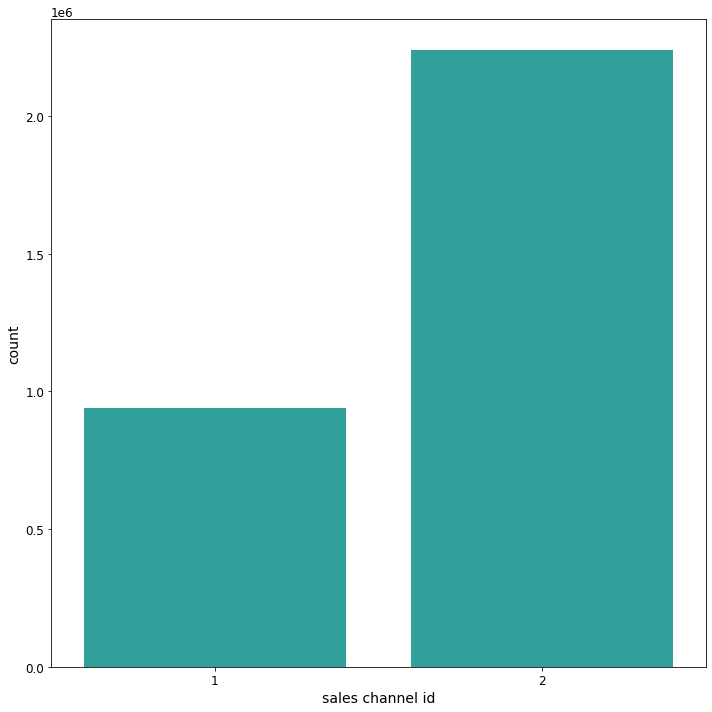

In [45]:
# Let's group the transactions by `sales_cahnnel_id` and count how many transactions we have in each group.
transactions_channel_sorted = group_data_by(data=transactions.sample(frac=0.1),
                                            groupby='sales_channel_id',
                                            countby='article_id')

# We can see that almost twice as many sales were done through the second channel
plot_sns_bar(x=transactions_channel_sorted['count'],
             y=transactions_channel_sorted['sales_channel_id'],
             x_label='sales channel id',
             y_label='count',
             vertical=True)

### price

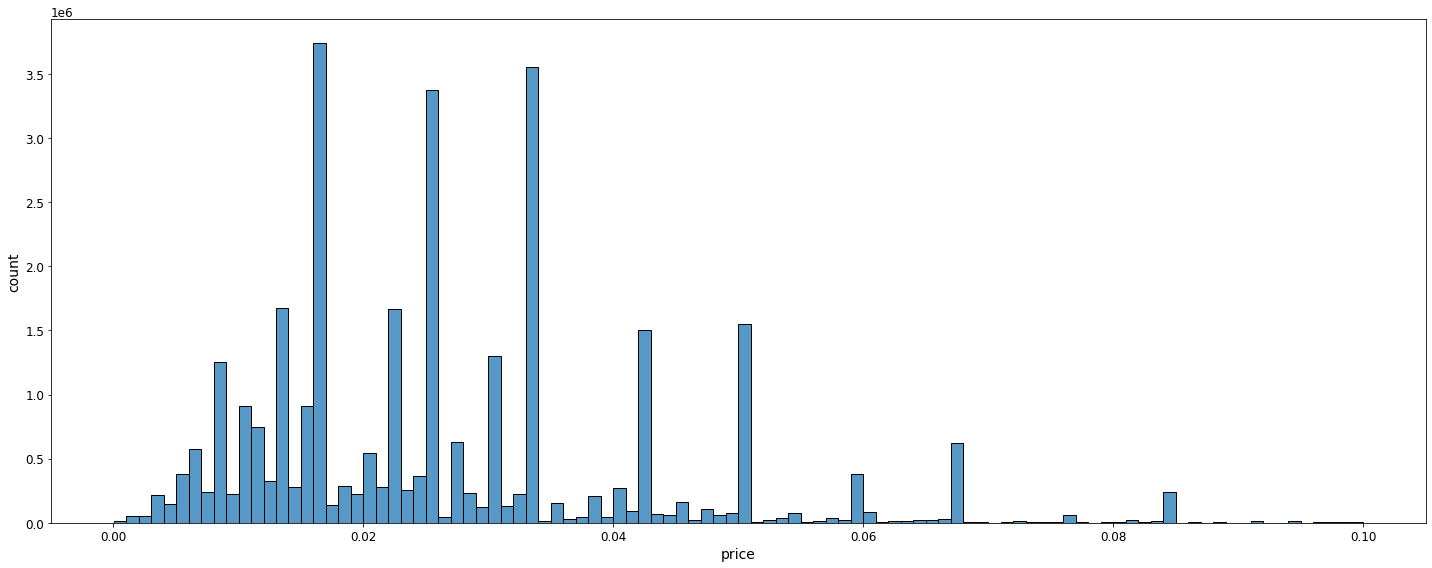

In [46]:
price_filtered = transactions.loc[transactions['price'] < 0.1]
plot_sns_hist(data=price_filtered,
              x='price',
              x_label='price',
              y_label='count',
              vertical=True,
              bins=100)

### price_outliers

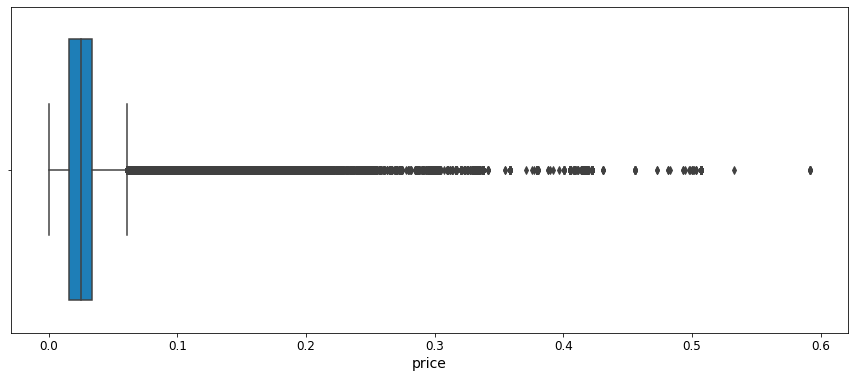

In [47]:
# From this plotbox we can see that the prices are fairly centered, but only in the interval [0, 0.06]
# The median (Q2) is placed in the center of the interval [Q1, Q3], which is good
# In this interval, the distribution is almost Normal

# But, we can also see that the dataset has a lot of outliers, especially high prices
# That's the reason I've filtered the prices so much in the previous histogram

plot_sns_boxplot(data=transactions, x='price')

In [48]:
articles.head(1)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [49]:
# Let's select the most relevant attributes from the `articles` df
articles_red = articles[['article_id', 'prod_name', 'product_type_name',
                         'product_group_name', 'index_name', 'garment_group_name']]
articles_red.head(1)

,article_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Ladieswear,Jersey Basic


In [50]:
# Now, merge the `articles_red` df with `transactions` df
transactions_merged = transactions.merge(articles_red, on='article_id')

In [51]:
transactions_merged.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,"Under-, Nightwear"


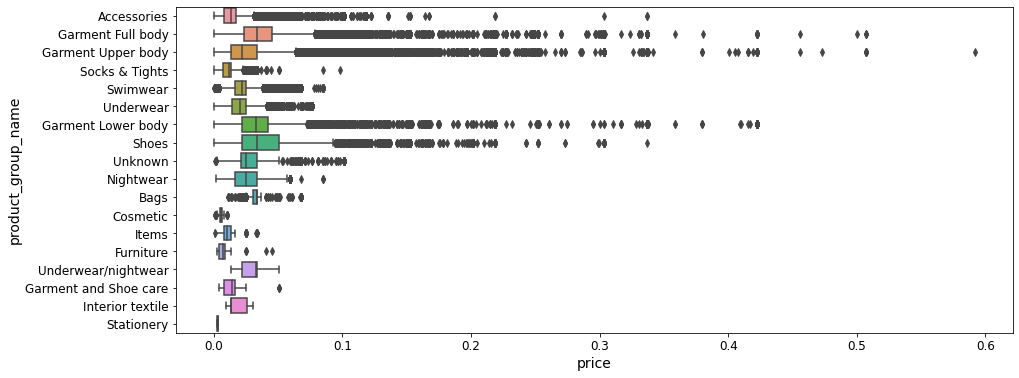

In [52]:
# In the following boxplot, we can see outliers for `group_name` prices
# Lower/Upper/Full body have a lot of outliers (maybe because we can think of some unique collections vs. casual garment)
# Accessories have also some high price variance

plot_sns_boxplot(data=transactions_merged.sample(frac=0.1),
                 x='price',
                 y='product_group_name')

In [53]:
# Let's look inside the `Garment Upper Body` category
upper_body = transactions_merged[transactions_merged['product_group_name'].str.contains('Upper')]
upper_body.head()

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
1067,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,Inca Jumper,Sweater,Garment Upper body,Divided,Knitwear
1068,2018-09-20,0fa69953e58a4b84ad466f4e10052324f811f3f0ee9174...,505221004,0.015237,2,Inca Jumper,Sweater,Garment Upper body,Divided,Knitwear
1069,2018-09-20,104dddd377a3542da33552b3a65752d03e196b4fdf8f36...,505221004,0.015237,2,Inca Jumper,Sweater,Garment Upper body,Divided,Knitwear
1070,2018-09-20,3e29d9eaefe0b553b1bb979bfbae8aca05a14c2876b72a...,505221004,0.015237,2,Inca Jumper,Sweater,Garment Upper body,Divided,Knitwear
1071,2018-09-20,5db11424a351368cec8b417a5a8952980e88942ecb1288...,505221004,0.015237,2,Inca Jumper,Sweater,Garment Upper body,Divided,Knitwear


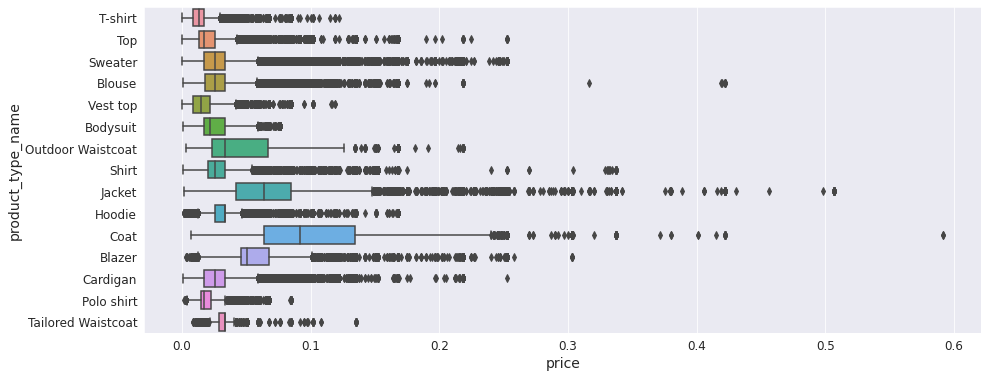

In [54]:
# Jackets, Coats, Shirts or Blouses have a high price variance
# That's ok, some special collections are much more expensive than regular clothes
# Looking at the Bodysuits, we can see very little variance

plot_sns_boxplot(data=upper_body.sample(frac=0.25),
                 x='price',
                 y='product_type_name')

### total_daily_sales

In [55]:
transactions_merged.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,"Under-, Nightwear"


In [56]:
transactions_t_dat_sorted = transactions     \
    .groupby('t_dat')['price']               \
    .agg(['sum', 'mean'])                    \
    .sort_values(by='t_dat', ascending=True) \
    .reset_index()
    
transactions_t_dat_sorted.head()

,t_dat,sum,mean
0,2018-09-20,1415.345847,0.029243
1,2018-09-21,1419.262305,0.029852
2,2018-09-22,530.437627,0.030079
3,2018-09-23,1593.783085,0.030515
4,2018-09-24,1407.609610,0.030611


In [57]:
len_t_dates  = transactions_t_dat_sorted.shape[0]
step_t_dates = 10
idx_list     = [idx for idx in range(1, len_t_dates, step_t_dates)]
print('Sampled days: ', idx_list)

Sampled days:  [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731]


Graph of sales starting from date 2018-09-21 00:00:00, until 2020-09-20 00:00:00 with step of size 10 days


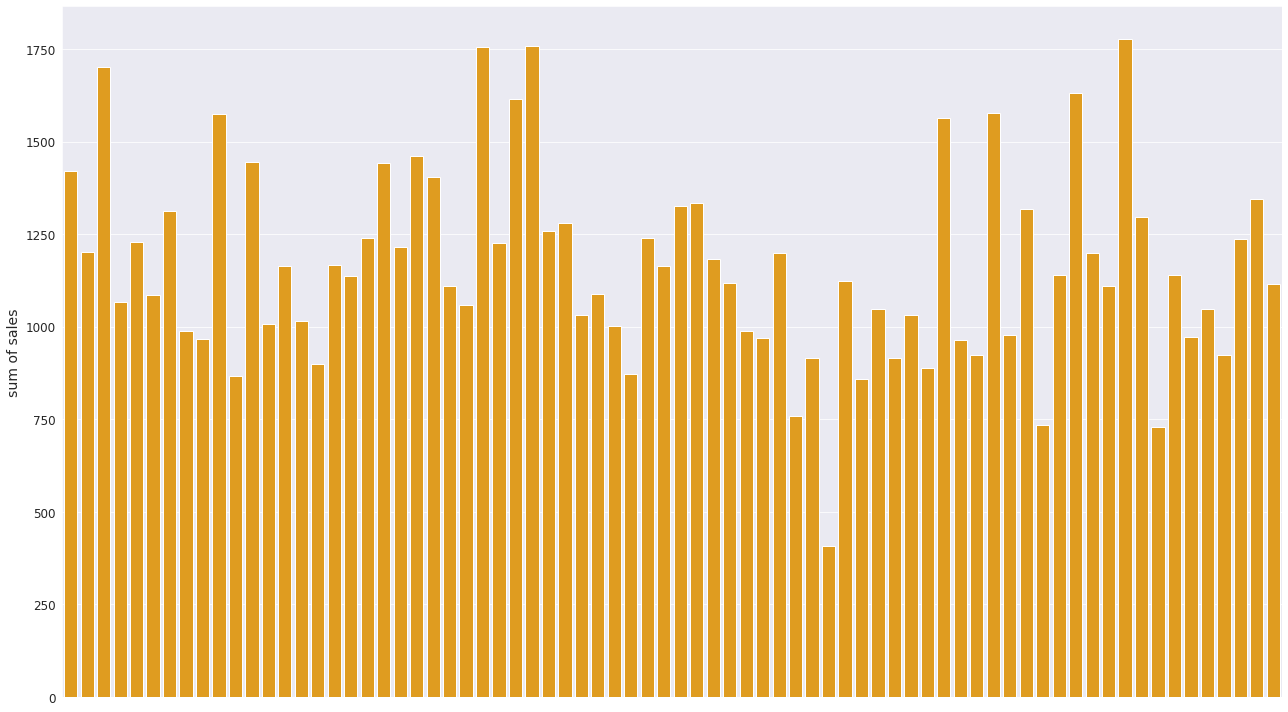

In [58]:
first_day = transactions_t_dat_sorted['t_dat'][idx_list[0]]
last_day  = transactions_t_dat_sorted['t_dat'][idx_list[len(idx_list)-1]]
print(f'Graph of sales starting from date {first_day}, until {last_day} with step of size {step_t_dates} days')

plot_sns_bar(x=transactions_t_dat_sorted['sum'][idx_list],
             y=transactions_t_dat_sorted['t_dat'][idx_list],
             x_label='',
             y_label='sum of sales',
             vertical=True)

### total_monthly_sales

In [59]:
transactions_merged.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,"Under-, Nightwear"


In [60]:
# Let's create a new pd df for dividing the sales in months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_dict = dict(zip(range(len(months)), months))

months_sales = pd.DataFrame()
months_sales['month'] = transactions_merged['t_dat'].dt.month.map(months_dict)
months_sales['price'] = transactions_merged['price']

months_sales_sorted = months_sales          \
    .groupby('month')['price']              \
    .agg(['sum'])                           \
    .sort_values(by='sum', ascending=False) \
    .reset_index()

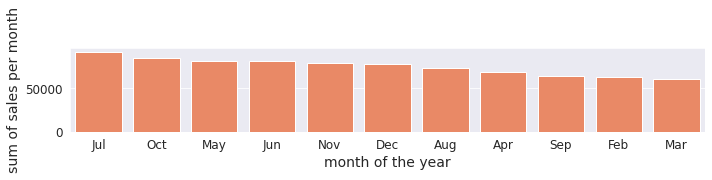

In [61]:
plot_sns_bar(x=months_sales_sorted['month'],
             y=months_sales_sorted['sum'],
             x_label='month of the year',
             y_label='sum of sales per month')

### total_weekly_sales

In [62]:
transactions_merged.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,"Under-, Nightwear"


In [63]:
# Let's create a new pd df for dividing the sales in days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_dict = dict(zip(range(len(days)), days))

days_sales = pd.DataFrame()
days_sales['day']   = transactions_merged['t_dat'].dt.weekday.map(days_dict)
days_sales['price'] = transactions_merged['price']

days_sales_sorted = days_sales              \
    .groupby('day')['price']                \
    .agg(['sum'])                           \
    .sort_values(by='sum', ascending=False) \
    .reset_index()

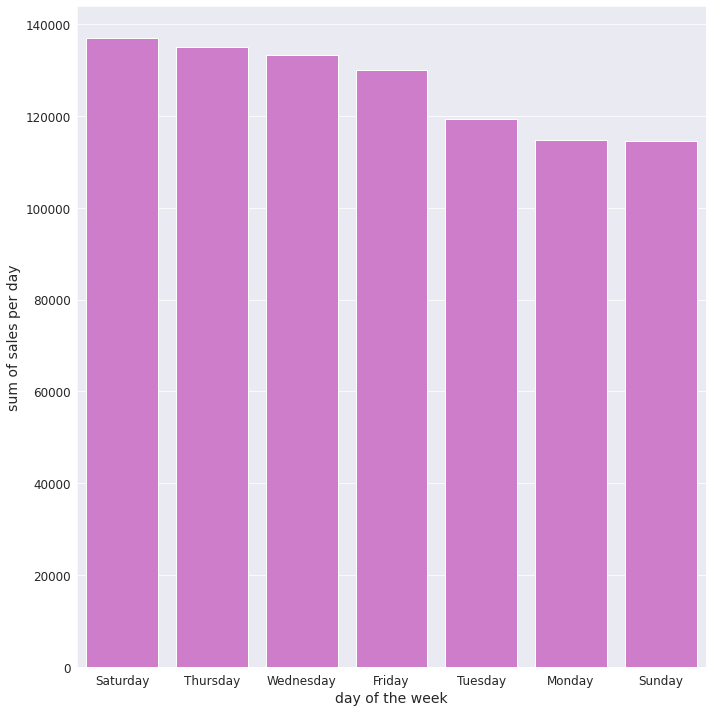

In [64]:
plot_sns_bar(x=days_sales_sorted['day'],
             y=days_sales_sorted['sum'],
             x_label='day of the week',
             y_label='sum of sales per day')

## Change of price in time for some articles

In [65]:
transactions_merged.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id,prod_name,product_type_name,product_group_name,index_name,garment_group_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,Atlanta Push Body Harlow,Underwear body,Underwear,Lingeries/Tights,"Under-, Nightwear"


In [66]:
articles.head(1)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [67]:
articles['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

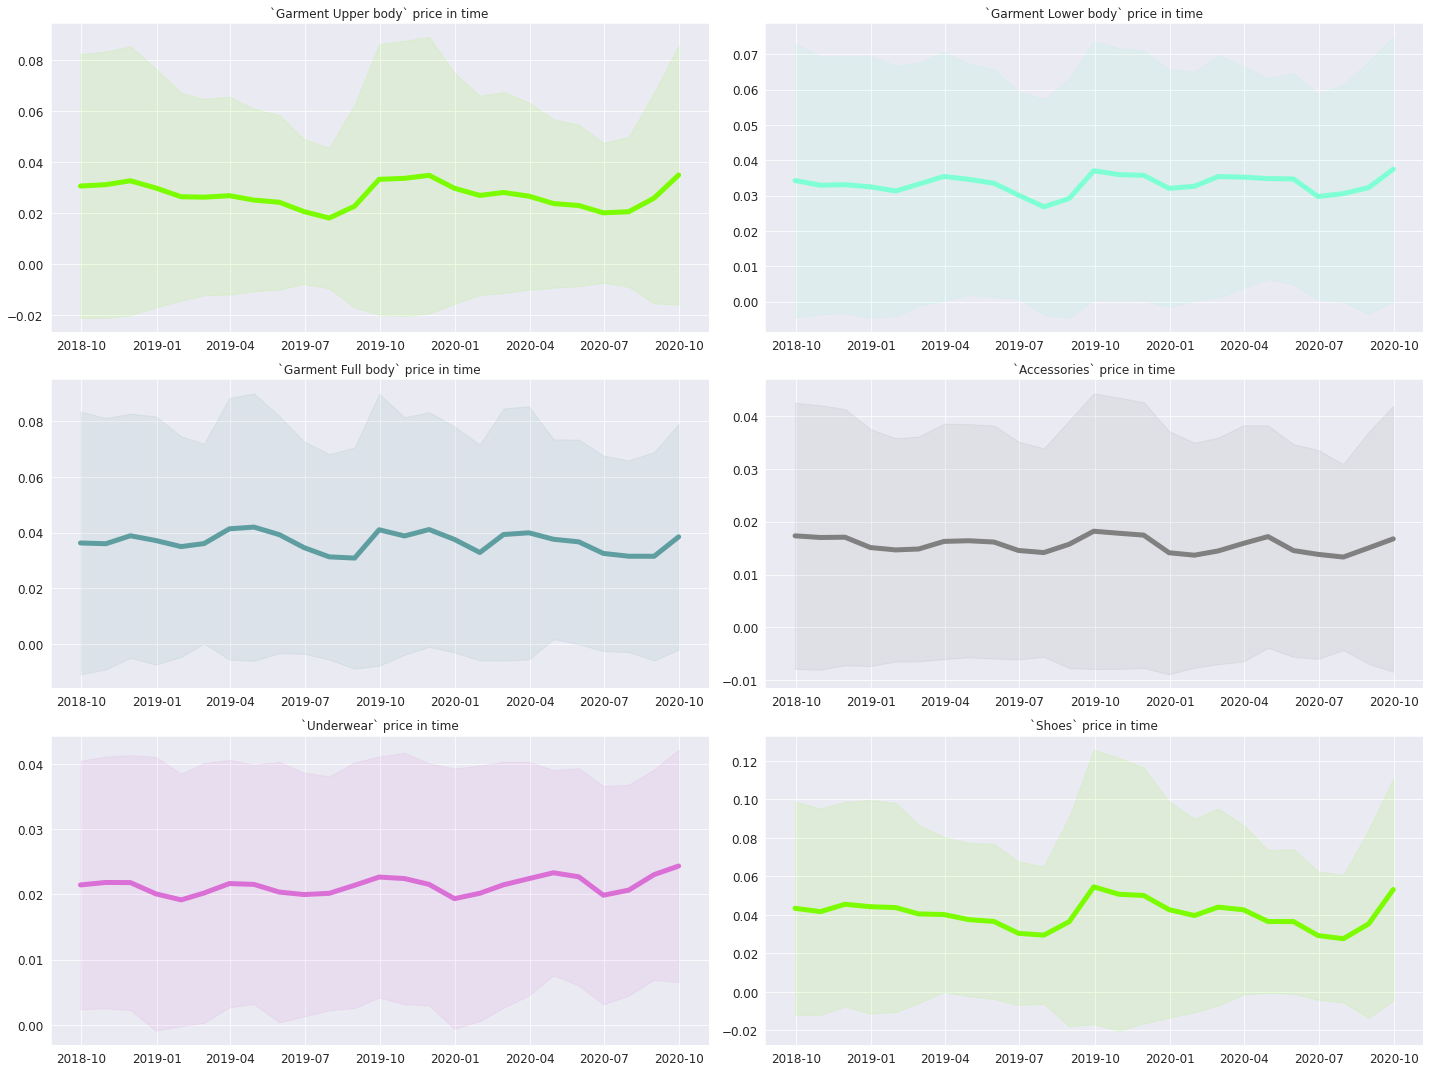

In [68]:
product_list = ['Garment Upper body', 'Garment Lower body',
                'Garment Full body', 'Accessories', 'Underwear', 'Shoes']

fig_cols = 2
fig_rows = math.ceil(len(product_list) / fig_cols)
fig, ax  = plt.subplots(fig_rows, fig_cols, figsize=(20, 15))

k = 0
for i in range(fig_rows):
    for j in range(fig_cols):
        # Sanity check
        if k >= len(product_list):
            ax[i, j].set_visible(False)
            continue
        
        # Current product in the list
        product = product_list[k]
        articles_curr_prod = transactions_merged[transactions_merged['product_group_name'] == product]
        
        # Compute the mean price over time
        series_mean = articles_curr_prod[['t_dat', 'price']]         \
            .groupby(pd.Grouper(key='t_dat', freq='M'))              \
            .mean()                                                  \
            .fillna(0)                                               \

        # Compute the std deviation from the mean
        series_std  = articles_curr_prod[['t_dat', 'price']]         \
            .groupby(pd.Grouper(key='t_dat', freq='M'))              \
            .std()                                                   \
            .fillna(0)                                               \

        # Plot the main line
        rnd_color = random.choice(COLORS)
        ax[i, j].plot(series_mean, linewidth=5, color=rnd_color)

        # Plot the 2 standard deviations
        ax[i, j].fill_between(series_mean.index,                                      \
                              (series_mean.values - 2 * series_std.values).flatten(), \
                              (series_mean.values + 2 * series_std.values).flatten(), \
                              color=rnd_color,                                        \
                              alpha=0.1)                                              \

        # Set title and labels
        ax[i, j].set_title(f'`{product}` price in time')

        # Move to the next product
        k += 1
            
plt.tight_layout()
plt.show()

## Pareto principle

In [69]:
pareto_df = transactions_merged[['article_id', 'price']]
pareto_df.head()

,article_id,price
0,663713001,0.050831
1,663713001,0.049475
2,663713001,0.050831
3,663713001,0.050831
4,663713001,0.050831


In [70]:
total_sales = transactions_merged['price'].sum()
total_sales

884645.9740508451

In [71]:
# Sort the `pareto_df` in descending order by `price`
pareto_sorted = pareto_df           \
    .groupby('article_id')['price'] \
    .sum()                          \
    .sort_values(ascending=False)   \

In [72]:
pareto_sorted.head()

article_id
706016001    1631.732102
706016002    1136.321085
568601006     939.268593
448509014     781.478390
706016003     692.195915
Name: price, dtype: float64

In [73]:
pareto_sorted.tail()

article_id
407663007    0.000678
520431003    0.000678
405310006    0.000475
569052001    0.000441
344625009    0.000424
Name: price, dtype: float64

In [74]:
# Let's see how much top 1% products contribute to the overall sales
top_1p_articles = pareto_sorted.head(int(pareto_sorted.shape[0] * 0.01))
print(f'~{round(top_1p_articles.sum() / total_sales * 100, 2)}% of the sales belongs from the top 1% products.')

~17.95% of the sales belongs from the top 1% products.


In [75]:
# Let's generalize: top i% articles contribute to the overall sales 
top_np_articles = []
for i in range(1, 101):
    top_articles = pareto_sorted.head(int(pareto_sorted.shape[0] * 0.01 * i))
    top_np_articles.append(top_articles.sum() / total_sales)

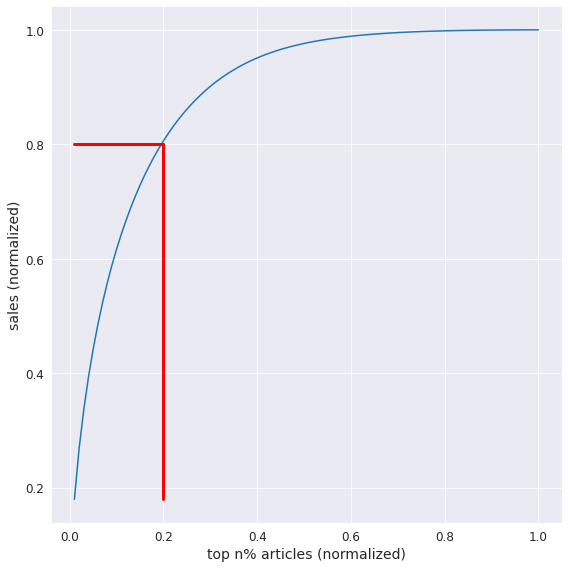

In [76]:
# We can now plot the graph describing the event: `top n% articles contribute to the overall sales with  x%`
plot_sns_lineplot(x=[i/100 for i in range(1, 101)],
                  y=top_np_articles,
                  x_label='top n% articles (normalized)',
                  y_label='sales (normalized)',
                  draw_pareto_line=True)

# As we can see, the top 20% products contribute to the overall sales with 80%
# "The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes"

### articles_with_images

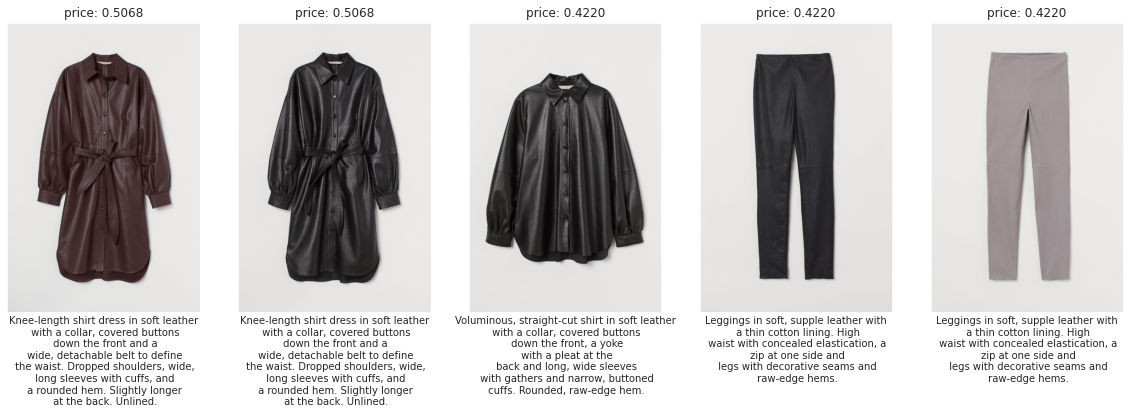

In [77]:
# Select the most 5 expensive articles in the last 3 days
max_price_articles = transactions[transactions.t_dat >= transactions.t_dat.max() - pd.Timedelta(days=3)].sort_values('price', ascending=False).iloc[:5][['article_id', 'price']]
plot_articles_images(max_price_articles)

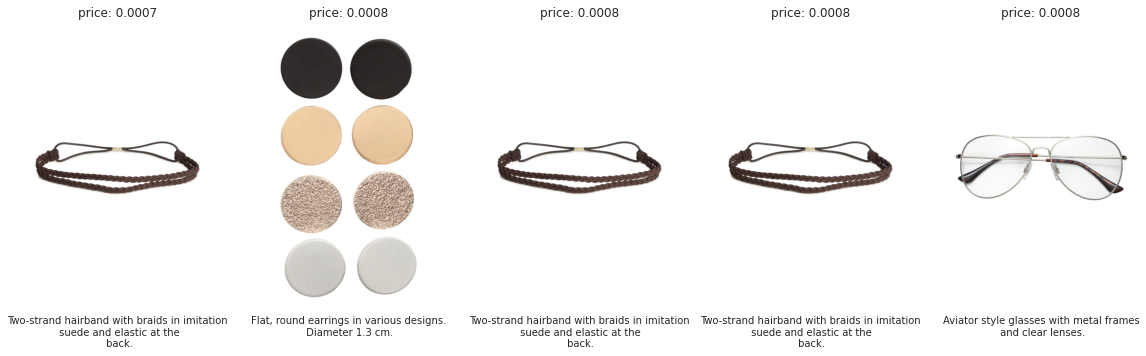

In [78]:
# Select the cheapest 5 articles in the last 3 days
min_price_articles = transactions[transactions.t_dat >= transactions.t_dat.max() - pd.Timedelta(days=3)].sort_values('price', ascending=True).iloc[:5][['article_id', 'price']]
plot_articles_images(min_price_articles)